COPY/PASTE FOR STARTER README:

## Problem Statement/Goal
 - Pull insights and see what I can do to predict a change.
 
 People who did the most sessions preferred which method?
 What other habits were formed by using more of the app?
 
Marajuana might be a great way for people to treat depression, anxiety and stress, at least in the short term before finding more sustainable and longterm solutions.  If one could build a model which could predict the potential change for a consumer, then a company might then be able to reccomend targeted suggestions for a specific customer based on what would be most effective and helpful for them.
 
 
 To Do:
  - Clean up EDA
  - Clean up what we have of the modeling done
  - Address the combining of the three models
  - Work on the Neural Network

## Imports

In [295]:
# Standard Imports
import pandas as pd   #loc[row_indexer,col_indexer]
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

# Model imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')
from time import time
from datetime import datetime

In [2]:
# Importing the data
df_anxiety = pd.read_excel('./data/Complete Final DAS MMJ Dataset_C3D0_201804001448125278.xlsx',
                            sheet_name='anxiety')
df_depression = pd.read_excel('./data/Complete Final DAS MMJ Dataset_C3D0_201804001448125278.xlsx',
                            sheet_name='depression')
df_stress = pd.read_excel('./data/Complete Final DAS MMJ Dataset_C3D0_201804001448125278.xlsx',
                            sheet_name='stress')

## Raw EDA

In [3]:
print('Stress DF     :', df_stress.shape)
print('Depression DF :', df_depression.shape)
print('Anxiety DF    :', df_anxiety.shape) 

Stress DF     : (3717, 12)
Depression DF : (3151, 12)
Anxiety DF    : (5085, 12)


# Cleaning DF

In [4]:
df_anxiety['symptom'] = 'anxiety'
df_depression['symptom'] = 'depression'
df_stress['symptom'] = 'stress'

df_raw = pd.concat([df_depression,df_anxiety,df_stress])
df = df_raw.reset_index().drop('index', axis = 1)

# Removing data with high potential for falsely provided information
mask = df['% cbd'] >= 0  # I'm not sure of how a product could have negative amounts of something.
df = df[mask]
mask = df['% thc'] >= 0 
df = df[mask]
mask = df['age'].abs() < 90 
df = df[mask]
mask = df['time lag (min)'] <= 180 # After three hours I suspect a potential for dropped memory of the change.
df = df[mask]

# Copying these series to be used post-get_dummies.
series_method  = df['admin_method']
series_symptom = df['symptom']

df = pd.get_dummies(df)

# Reinserting the columns incase I wish to still use them in this format.
df['admin_method'] = series_method
df['symptom'] = series_symptom

In [5]:
df.rename({
    'session/time'              : 'session', # As in Session #1 or Session #2 or Session #3 for a user.
    'time lag (min)'            : "time_lag",# Time it took from initial ingestion to when effects were tracked
    '% thc'                     : 'thc_%', 
    '% cbd'                     : 'cbd_%',
    'admin_method_Concentrate'  : 'concentrate',
    'admin_method_Dab Bubbler'  : 'dab_bubbler',
    'admin_method_Dab Portable' : 'dab_portable',
    'admin_method_Smoke'        : 'smoke',
    'admin_method_Vape'         : 'vape',
    'symptom_anxiety'           : 'symptom_a',
    'symptom_depression'        : 'symptom_d',
    'symptom_stress'            : 'symptom_s',
    'admin_method'              : 'method'
}, axis = 1, inplace = True)

# Saving for safety and to make sure that this is always up to date.
df.to_csv('./data/all_symptoms_cleaned.csv', index=False)

# ML DF EDA

In [6]:
df.describe().T

count         mean          std    min     25%      50%  \
session       10065.0    16.337506    23.878303   1.00     2.0     7.00   
userid        10065.0  2687.544163  1277.586521  93.00  1670.0  2717.00   
gender        10065.0     0.514456     0.499816   0.00     0.0     1.00   
age           10065.0    33.161749     9.289252  18.00    25.0    33.00   
dose          10065.0     6.247789     3.044516   1.00     4.0     6.00   
time_lag      10065.0    34.534903    28.122963   0.10    20.8    23.90   
thc_%         10065.0    15.973149     8.993642   0.04    12.0    17.70   
cbd_%         10065.0     2.980585     6.441241   0.00     0.0     0.07   
before        10065.0     5.970492     2.065892   1.00     5.0     6.00   
after         10065.0     2.535420     2.138061   0.00     1.0     2.00   
change        10065.0     3.435072     2.264193  -9.00     2.0     3.00   
concentrate   10065.0     0.034675     0.182963   0.00     0.0     0.00   
dab_bubbler   10065.0     0.006855     0.082517   0.00     0.0     0.00   
dab_portable  10065.0     0.001093     0.033043   0.00     0.0     0.00   
smoke         10065.0     0.525882     0.499354   0.00     0.0     1.00   
vape          10065.0     0.431495     0.495309   0.00     0.0     0.00   
symptom_a     10065.0     0.429309     0.495002   0.00     0.0     0.00   
symptom_d     10065.0     0.265276     0.441502   0.00     0.0     0.00   
symptom_s     10065.0     0.305415     0.460606   0.00     0.0     0.00   

                 75%     max  
session         20.0   196.0  
userid        3633.0  5578.0  
gender           1.0     1.0  
age             39.0    87.0  
dose            10.0    10.0  
time_lag        40.6   179.8  
thc_%           19.9   100.0  
cbd_%            1.0    99.0  
before           7.0    10.0  
after            4.0    10.0  
change           5.0    10.0  
concentrate      0.0     1.0  
dab_bubbler      0.0     1.0  
dab_portable     0.0     1.0  
smoke            1.0     1.0  
vape             1.0     1.0  
symptom_a        1.0     1.0  
symptom_d        1.0     1.0  
symptom_s        1.0     1.0

In [7]:
print('Number of users in study:', len(df['userid'].value_counts())) # (Post data cleaning)

Number of users in study: 1062


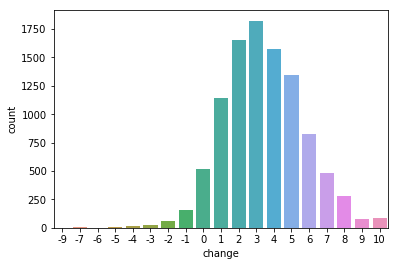

In [8]:
sns.countplot(df['change']);

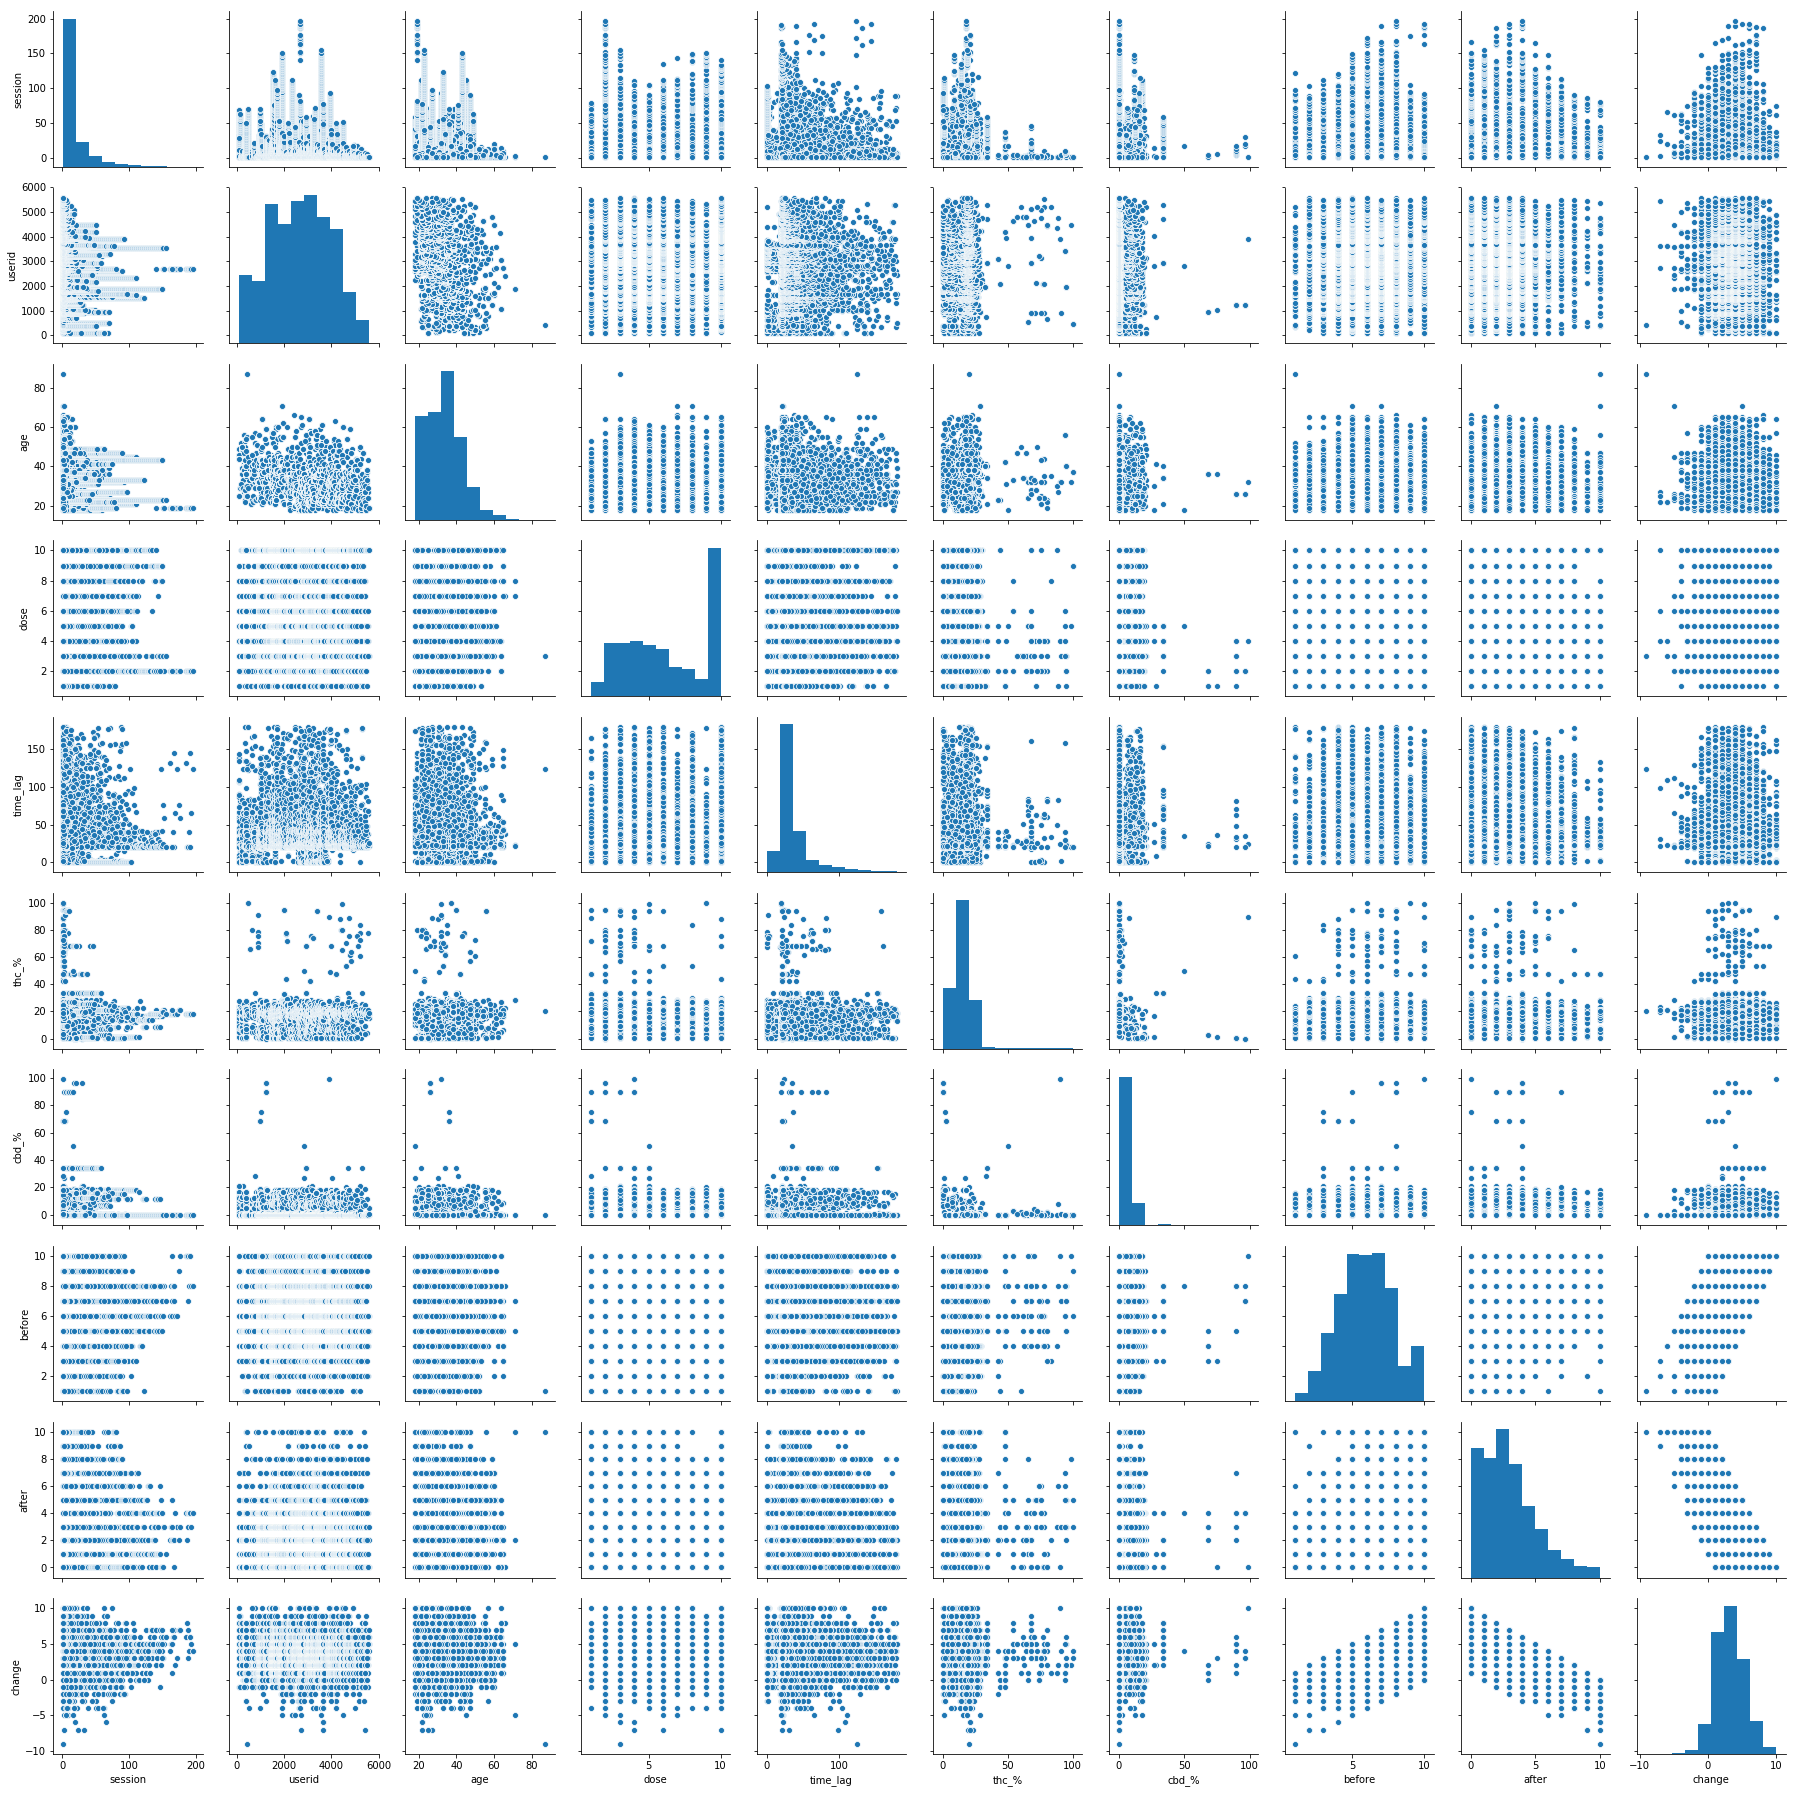

In [9]:
# Shortening the df to only the numerical data of note.
df_short = df.drop(['gender','symptom_a', 'symptom_d',
       'symptom_s', 'concentrate', 'dab_bubbler',
       'dab_portable', 'smoke', 'vape', 'symptom', 'method'], axis = 1)
sns.pairplot(df_short);

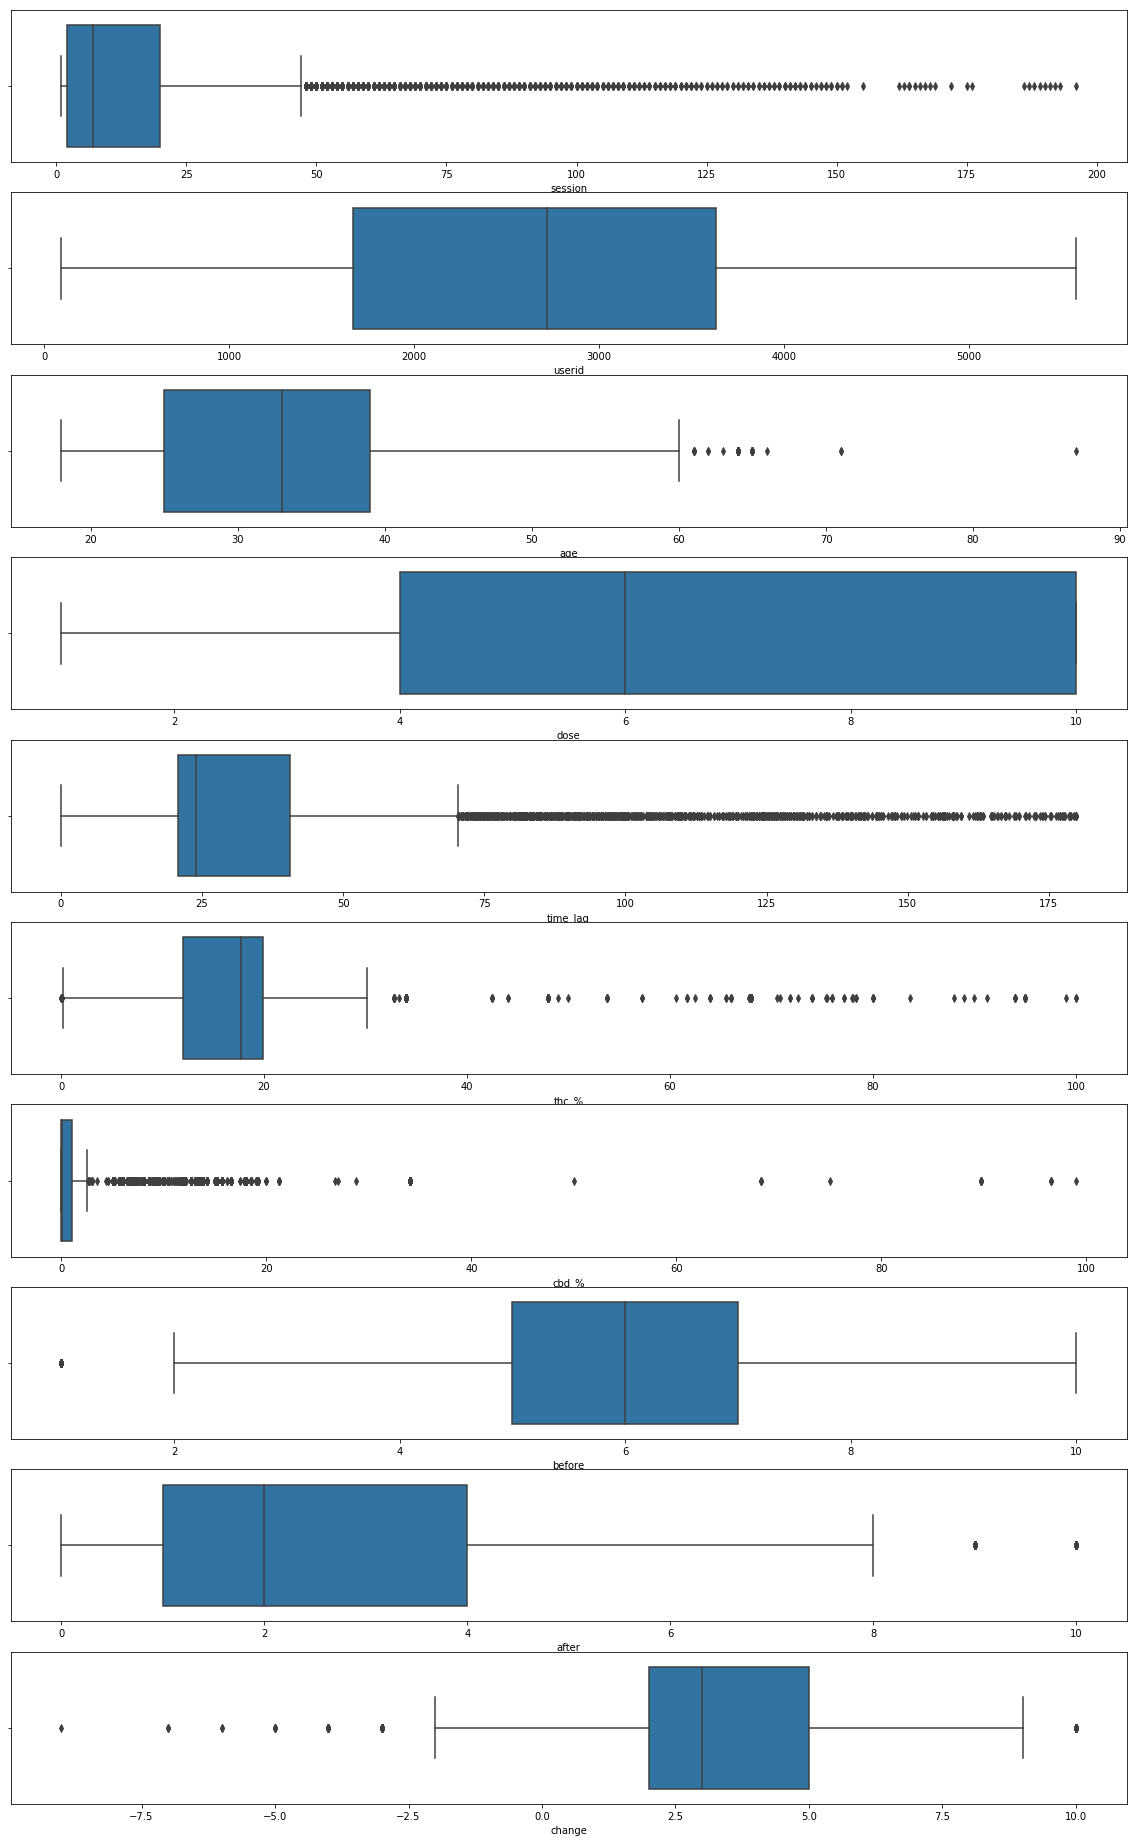

In [10]:
fig, axes = plt.subplots(len(df_short.columns),     
                   figsize = (20,33)) # Size
count = 0
for col in df_short.columns:
    sns.boxplot(df_short[col], ax = axes[count])
    count += 1

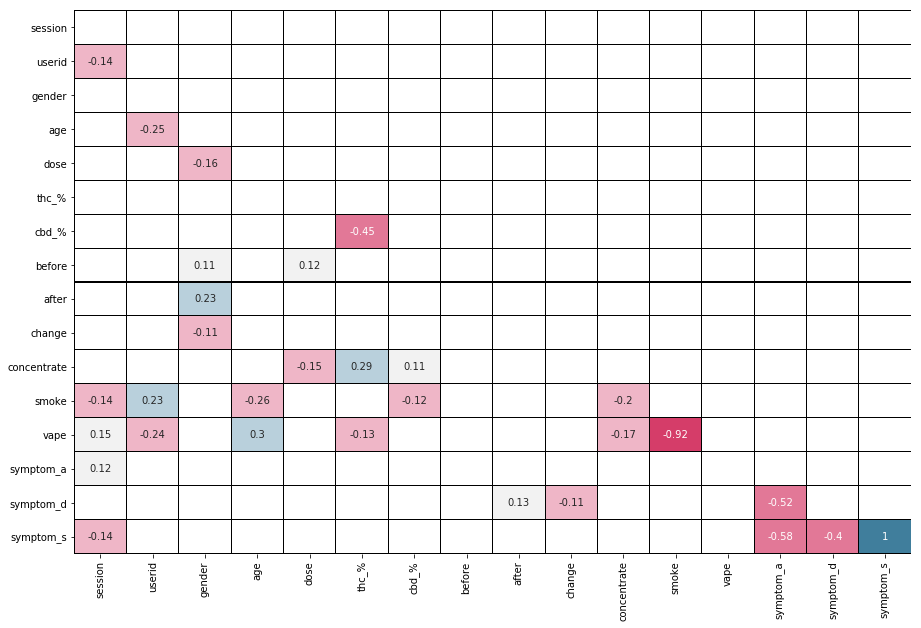

In [11]:
df_cor          = df.drop(['time_lag', 'dab_bubbler', 'dab_portable'],axis = 1).corr() 
# Dropped because nothing is signifigantly correlated to them
list_half_inner = []
list_half_outer = []

# Creating a blank-ish DF with the dementions that match the correlation matrix.
for i in range(df_cor.shape[0]):
    list_half_inner.append(True)
    list_half_outer.append(list_half_inner)
mask_half = pd.DataFrame(list_half_outer, columns= df_cor.columns, index=df_cor.columns)

# Turning it into a mask and cutting it in half.
for num in range(mask_half.shape[1]):
    mask_half.iloc[num,num:mask_half.shape[1]] = False

# Manually dropping certain values because they don't tell us anything by being correlated.
mask_half.loc['after','before'] = False
mask_half.loc['change','before':'after'] = False 

mask_half.iloc[df_cor.shape[0] - 1,df_cor.shape[1] - 1] = True
    
# Mask for limiting which correlations are shown.
mask_cor_limit = (df_cor > 0.1) | (df_cor < -0.1)
plt.figure(figsize=(15,10))

sns.heatmap(df_cor[mask_cor_limit][mask_half],
            annot = True, cbar=False, 
            linewidths= .01, linecolor='black', cmap=sns.diverging_palette(0, 230, n=7, center='light'));


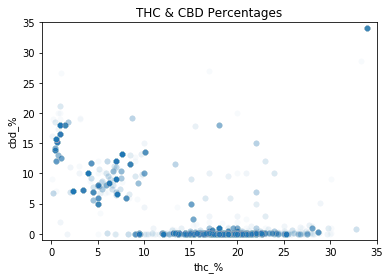

In [150]:
axes = plt.gca()
axes.set_xlim([-1,35])
axes.set_ylim([-1,35])
axes.set_title('THC & CBD Percentages')
sns.scatterplot(df['thc_%'],df['cbd_%'],alpha=0.03);

In [13]:
mask = df.corrwith(df['change']).abs() > 0.01
[mask]

[session         False
 userid           True
 gender           True
 age              True
 dose             True
 time_lag         True
 thc_%            True
 cbd_%            True
 before           True
 after            True
 change           True
 concentrate      True
 dab_bubbler      True
 dab_portable    False
 smoke            True
 vape             True
 symptom_a        True
 symptom_d        True
 symptom_s        True
 dtype: bool]

# Modeling

## Imports, Functions & General Data Prep

In [453]:
# Model imports
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB

from keras.models import Sequential
from keras.layers import Dense
from keras import backend

In [454]:
def Reg_metrics(y_real, y_hat):
    print('RMSE            :',np.sqrt(metrics.mean_squared_error(y_real, y_hat)))   # Goal=0, Avg Distance
    print('Median Abs Error:',metrics.median_absolute_error(y_real,y_hat))          # Goal=0, Median Distance
    print('R Squared       :',metrics.r2_score(y_real, y_hat))          # Goal=1, Percent model can explain
    return

In [455]:
df_results = pd.DataFrame(columns=['model', 'features', 'parameters',
    'train_RMSE', 'train_Median_error', 'train_R_squared',
    'test_RMSE',  'test_Median_error',  'test_R_squared', 'time'])

def run_model(model, X, y, results_dataframe, save = True, 
              rando_state = 76, is_neural_network = False, 
              NN_epochs = 10, NN_batch_size = 32, NN_verbose = 0):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = rando_state)

    if is_neural_network == False:
        # Performing normal running of model.
        model      = model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        pred_test  = model.predict(X_test)
        dict_model = {'model' : re.findall(r'^[^@]+\(', str(model))[0].strip("("),
            'parameters'      : model.get_params()}
        
    elif is_neural_network == True:
        # Running model for Neural Networks
        results = model.fit(X_train, y_train, 
                    epochs= NN_epochs, 
                    batch_size = NN_batch_size,
                    verbose = NN_verbose,
                    validation_data = (X_test,y_test))
        pred_train = model.predict(X_train)
        pred_test  = model.predict(X_test)
        dict_model = {'model' : "Neural Network",
            'parameters'      : {'layers' : [layer.get_config()['units'] for layer in results.model.layers],
                                 'batch_size' : NN_batch_size,
                                 'epochs'     : NN_epochs}}
    
    else:
        print("A non-boolian value was passed to is_neural_network.  This is an error.")
        return
    
    # Adding non-model dependant information to dict_model
    dict_model['time']               = datetime.fromtimestamp(time()).strftime('%m/%d/%Y, %H:%M:%S')
    dict_model['features']           = [feature for feature in X.columns]
    dict_model['train_RMSE']         = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
    dict_model['train_Median_error'] = metrics.median_absolute_error(y_train, pred_train)
    dict_model['train_R_squared']    = metrics.r2_score(y_train, pred_train)
    dict_model['test_RMSE']          = np.sqrt(metrics.mean_squared_error(y_test, pred_test))
    dict_model['test_Median_error']  = metrics.median_absolute_error(y_test, pred_test)
    dict_model['test_R_squared']     = metrics.r2_score(y_test, pred_test)
    
    # Printing current results
    print(dict_model['model'] + ' Train')
    print('RMSE             : ' + str(dict_model['train_RMSE']))
    print('Median Abs Error : ' + str(dict_model['train_Median_error']))
    print('R Squared        : ' + str(dict_model['train_R_squared']))
    print('\n' + dict_model['model'] + ' Test')
    print('RMSE             : ' + str(dict_model['test_RMSE']))
    print('Median Abs Error : ' + str(dict_model['test_Median_error']))
    print('R Squared        : ' + str(dict_model['test_R_squared']))
    
    # Saving current results
    results_dataframe = results_dataframe.append(dict_model, ignore_index=True)
    if save == True:
        results_dataframe.to_csv('./data/modeling_results' + datetime.fromtimestamp(time()).strftime('%m_%d_%Y')
                          , index = False)
    
    return results_dataframe

In [456]:
# Used in Neural Network
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

### Notes:
 - Tactics skipped or dropped:
     - Nieve Bayes (Tried and wasn't very effective.)
     - PCA (Not needed.  We have too few features and can intuit which ones should be dropped.)
     - Ada (Not very effective and not my wheelhouse.)
     - Extra Trees (Random Forest functioned better.  This points to a potential prefrence for bagging and thus altering the ratio of certain data and/or the random splits of Extra Trees proved ueless for this data.)

 - Tactics to be tested:
     - Feature Engineering
     - Gridsearch
     - Pipeline?
     - Attaching simpler models to Neural Network (I really like NNs.)
     - XG Boost?
     - Also, create a proper scoring function for K-Folds when I have some spare time.  Not a high priority, tho.
     - Run a single Decision Tree and try again to get the visualization to work.

## Standard Models

### Linear Regression

In [388]:
mask = df['change'] >= -2
X = df[mask][['session', 'userid', 'gender', 'age', 'dose', 'time_lag', 'thc_%',
       'cbd_%', 'before', 'concentrate', 'smoke', 'vape', 'symptom_a', 'symptom_d']]
y = df[mask]['change']

print('Linear Regression with all features.\n')
df_results = run_model(LinearRegression(), X, y, df_results)

Linear Regression with all features.

LinearRegression Train
RMSE             : 1.804783660528681
Median Abs Error : 1.1244333929366572
R Squared        : 0.3352873765521873

LinearRegression Test
RMSE             : 1.7757076993339183
Median Abs Error : 1.0986621710265285
R Squared        : 0.3326850629919986


In [389]:
mask = df['change'] >= -2
X = df[mask][['before', 'symptom_a']]
y = df[mask]['change']

print('Linear Regression with mostly just the "before" feature. ("symptom_a" is also included to keep X 2D.)\n')
df_results = run_model(LinearRegression(), X, y, df_results)

Linear Regression with mostly just the "before" feature. ("symptom_a" is also included to keep X 2D.)

LinearRegression Train
RMSE             : 1.8949521561320473
Median Abs Error : 1.2682710635893506
R Squared        : 0.26720900429112626

LinearRegression Test
RMSE             : 1.8501299238320839
Median Abs Error : 1.183540293826292
R Squared        : 0.27557680817302854


As far as linear regression is concerned, the most important value in our data is how somebody was feeling before attempting to medicate with cannabis.

## Gaussian Nieve Bayes
(Wanted to test this out just because I've never gotten a chance to.  Results aren't horrible, but also aren't super usable.)

In [390]:
mask = df['change'] >= -2
X = df[mask][['before', 'userid']]
y = df[mask]['change']

df_results = run_model(GaussianNB(), X, y, df_results)

GaussianNB Train
RMSE             : 2.336888260894669
Median Abs Error : 1.0
R Squared        : -0.11444725651058008

GaussianNB Test
RMSE             : 2.247735814976865
Median Abs Error : 1.0
R Squared        : -0.0692479388742413


## K-Neighbors, Random Forest & Gradient Boosting

In [391]:
mask = df['change'] >= -2
X = df[mask][['session', 'userid', 'gender', 'age', 'dose', 'time_lag', 'thc_%',
       'cbd_%', 'before', 'concentrate', 'smoke', 'vape', 'symptom_a', 'symptom_d']]
y = df[mask]['change']
df_results = run_model(KNeighborsRegressor(), X, y, df_results)
print('')
df_results = run_model(RandomForestRegressor(), X, y, df_results)
print('')
df_results = run_model(GradientBoostingRegressor(), X, y, df_results)

KNeighborsRegressor Train
RMSE             : 1.4482303527458822
Median Abs Error : 0.7999999999999998
R Squared        : 0.5719850719548817

KNeighborsRegressor Test
RMSE             : 1.8419499321956758
Median Abs Error : 1.0
R Squared        : 0.2819684412564307

RandomForestRegressor Train
RMSE             : 0.6463260646210212
Median Abs Error : 0.2999999999999998
R Squared        : 0.9147514568305455

RandomForestRegressor Test
RMSE             : 1.5132231326546917
Median Abs Error : 0.8999999999999999
R Squared        : 0.5153883681543784

GradientBoostingRegressor Train
RMSE             : 1.51468684829779
Median Abs Error : 0.9232319274475982
R Squared        : 0.5318022367110551

GradientBoostingRegressor Test
RMSE             : 1.570308126203967
Median Abs Error : 0.9829278165896795
R Squared        : 0.47813562978945545


In [392]:
df_results = run_model(model, X, y, df_results)
df_results.sort_values('test_RMSE')

model  \
4      RandomForestRegressor   
5  GradientBoostingRegressor   
0           LinearRegression   
3        KNeighborsRegressor   
1           LinearRegression   
2                 GaussianNB   

                                            features  \
4  [session, userid, gender, age, dose, time_lag,...   
5  [session, userid, gender, age, dose, time_lag,...   
0  [session, userid, gender, age, dose, time_lag,...   
3  [session, userid, gender, age, dose, time_lag,...   
1                                [before, symptom_a]   
2                                   [before, userid]   

                                          parameters  train_RMSE  \
4  {'bootstrap': True, 'criterion': 'mse', 'max_d...    0.646326   
5  {'alpha': 0.9, 'criterion': 'friedman_mse', 'i...    1.514687   
0  {'copy_X': True, 'fit_intercept': True, 'n_job...    1.804784   
3  {'algorithm': 'auto', 'leaf_size': 30, 'metric...    1.448230   
1  {'copy_X': True, 'fit_intercept': True, 'n_job...    1.894952   
2                                   {'priors': None}    2.336888   

   train_Median_error  train_R_squared  test_RMSE  test_Median_error  \
4            0.300000         0.914751   1.513223           0.900000   
5            0.923232         0.531802   1.570308           0.982928   
0            1.124433         0.335287   1.775708           1.098662   
3            0.800000         0.571985   1.841950           1.000000   
1            1.268271         0.267209   1.850130           1.183540   
2            1.000000        -0.114447   2.247736           1.000000   

   test_R_squared                  time  
4        0.515388  07/15/2019, 14:46:31  
5        0.478136  07/15/2019, 14:46:31  
0        0.332685  07/15/2019, 14:46:29  
3        0.281968  07/15/2019, 14:46:30  
1        0.275577  07/15/2019, 14:46:29  
2       -0.069248  07/15/2019, 14:46:30

# Cannabis Clustering
Attempting Clustering for the amount of Cannabis Injested during a session and/or clustering the products thc & cbd percentages.  
There seems to be a few clusters when viewing the scatter plot of thc and cbd percentages.  I'm curious if these clusters might shed a light on other potential information.

In [485]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from random import seed

In [539]:
df_dbs_results = pd.DataFrame(columns=['eps', 'min_samples', 'silhouette'])

DBS 0.6686208678882408


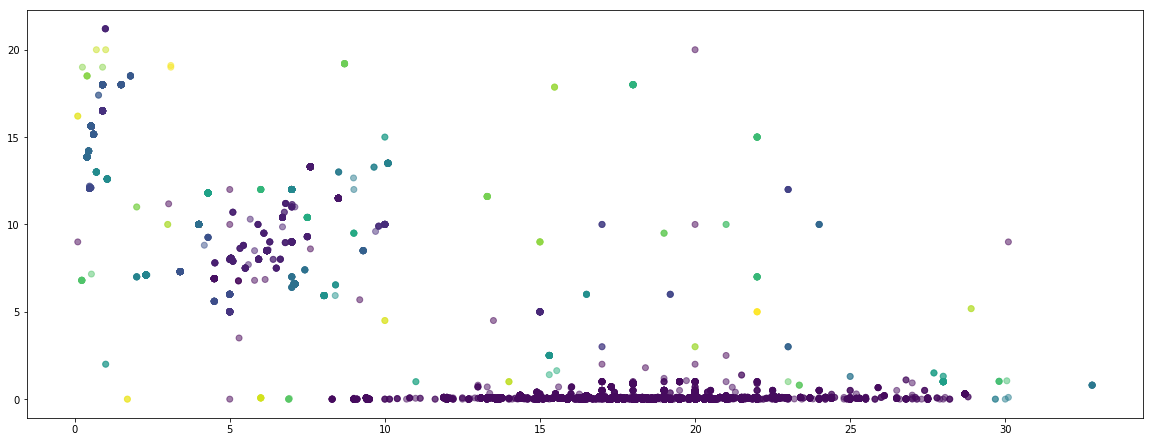

In [533]:
seed(76)
mask = (df['thc_%'] < 35) & (df['cbd_%'] < 25)
X_cluster = df[mask][['thc_%', 'cbd_%']]
df_cluster= X_cluster

model_DBS = DBSCAN(0.7, 2).fit(X_cluster)
df_cluster['y_DBS'] = model_DBS.fit_predict(X_cluster)
score_sil = silhouette_score(df_cluster,model_DBS.labels_)
print('DBS', score_sil)
plt.figure(figsize = (20,7.5))
plt.scatter(df_cluster['thc_%'],df_cluster['cbd_%'], c = df_cluster['y_DBS'], alpha=0.5);
df_dbs_results = df_dbs_results.append({'eps'         : model_DBS.get_params()['eps'], 
                                        'min_samples' : model_DBS.get_params()['min_samples'], 
                                        'silhouette'  : score_sil}, ignore_index = True)

I've decided to essentially gridsearch instead of going through every option by hand.

In [544]:
seed(76)
mask = (df['thc_%'] < 35) & (df['cbd_%'] < 25)
X_cluster = df[mask][['thc_%', 'cbd_%']]
df_cluster= X_cluster

for eps in [0.3,0.5,0.7,0.9, 1.1]:
    for min_samples in [1,2,3]:
        model_DBS = DBSCAN(eps, min_samples).fit(X_cluster)
        df_cluster['y_DBS'] = model_DBS.fit_predict(X_cluster)
        score_sil = silhouette_score(df_cluster,model_DBS.labels_)
        df_dbs_results = df_dbs_results.append({'eps'         : model_DBS.get_params()['eps'], 
                                                'min_samples' : model_DBS.get_params()['min_samples'], 
                                                'silhouette'  : score_sil}, ignore_index = True)

In [547]:
df_dbs_results.sort_values('silhouette')

eps  min_samples  silhouette
2   0.3          3.0    0.751158
8   0.7          3.0    0.752187
5   0.5          3.0    0.752279
11  0.9          3.0    0.753027
14  1.1          3.0    0.755444
1   0.3          2.0    0.757789
4   0.5          2.0    0.758865
7   0.7          2.0    0.759454
0   0.3          1.0    0.760114
10  0.9          2.0    0.760265
3   0.5          1.0    0.760729
13  1.1          2.0    0.760818
6   0.7          1.0    0.761099
9   0.9          1.0    0.761514
12  1.1          1.0    0.761758

 A better strategy might be implementing lines that would seperate the three clusters.  
 one for thc > cbd, 
 one for thc ~ cbd and 
 one for thc < cbd.
 
 Then, we take the dose and method as other axes to then guesstimate the amount of both chemicals that people are introducing into their systems.

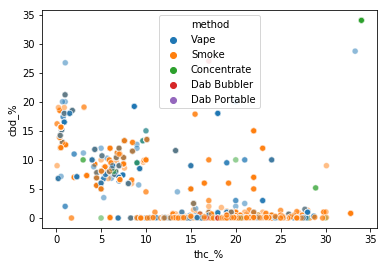

In [212]:
mask = (df['thc_%'] < 35) & (df['cbd_%'] < 35)
sns.scatterplot(df[mask]['thc_%'],df[mask]['cbd_%'], hue = df[mask]['method'], alpha=0.5);

In [458]:
df['method'].value_counts()

Smoke           5293
Vape            4343
Concentrate      349
Dab Bubbler       69
Dab Portable      11
Name: method, dtype: int64

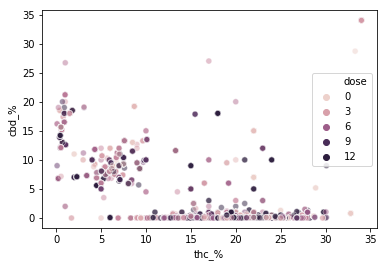

In [213]:
mask = (df['thc_%'] < 35) & (df['cbd_%'] < 35)
sns.scatterplot(df[mask]['thc_%'],df[mask]['cbd_%'], hue = df[mask]['dose'], alpha=0.5);

In [462]:
mask = df['vape'] == True
df[mask]['dose'].value_counts(normalize = True)

10    0.286668
3     0.118121
6     0.117430
4     0.114667
5     0.112134
2     0.074833
7     0.066314
8     0.055031
9     0.034538
1     0.020262
Name: dose, dtype: float64

In [463]:
mask = df['smoke'] == True
df[mask]['dose'].value_counts(normalize = True)

10    0.327980
2     0.122048
4     0.102966
5     0.097676
3     0.088797
6     0.079917
8     0.057623
7     0.053278
9     0.035708
1     0.034007
Name: dose, dtype: float64

# Attempting polynomial features

In [395]:
mask = df['change'] >= -2
X = df[mask][['session', 'userid', 'gender', 'age', 'dose', 'time_lag', 'thc_%',
       'cbd_%', 'before', 'concentrate', 'smoke', 'vape', 'symptom_a', 'symptom_d']]
X_poly = PolynomialFeatures().fit_transform(X)

y = df[mask]['change']

df_results = run_model(LinearRegression(), pd.DataFrame(X_poly), y, df_results)
print('')
df_results = run_model(RandomForestRegressor(), pd.DataFrame(X_poly), y, df_results)

LinearRegression Train
RMSE             : 1.6932421052376687
Median Abs Error : 1.0759880336967607
R Squared        : 0.41491125451620514

LinearRegression Test
RMSE             : 1.7002831358583157
Median Abs Error : 1.1025198793548912
R Squared        : 0.3881705393128845
RandomForestRegressor Train
RMSE             : 0.6579517606760756
Median Abs Error : 0.2999999999999998
R Squared        : 0.9116570835619257

RandomForestRegressor Test
RMSE             : 1.581078210181035
Median Abs Error : 0.9000000000000004
R Squared        : 0.4709525841165053


# Stacking/Feeding models to other models

In [ ]:
# Creating the modeled Data Frame
mask = df['change'] >= -2
X = df[mask][['session', 'userid', 'gender', 'age', 'dose', 'time_lag', 'thc_%',
       'cbd_%', 'before', 'concentrate', 'smoke', 'vape', 'symptom_a', 'symptom_d']]
y = df[mask]['change']
X_train_modeled, X_test_modeled, y_train_modeled, y_test_modeled = train_test_split(X, y, random_state=42)

In [85]:
# Generating the Linear Regression Responces to the Data Frame
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=76)
model_lin = LinearRegression().fit(X_train, y_train)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=77)
X_train_modeled['y_LinReg'] = model_lin.predict(X_train)
X_test_modeled['y_LinReg'] = model_lin.predict(X_test)

In [88]:
# K Neighbors
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)
model_KNeighbors = KNeighborsRegressor().fit(X_train, y_train)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=79)
X_train_modeled['y_KNeighbors'] = model_KNeighbors.predict(X_train)
X_test_modeled['y_KNeighbors'] = model_KNeighbors.predict(X_test)

In [89]:
# Random Forest
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=80)
model_RForest = RandomForestRegressor().fit(X_train, y_train)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=81)
X_train_modeled['y_RForest'] = model_RForest.predict(X_train)
X_test_modeled['y_RForest'] = model_RForest.predict(X_test)

In [90]:
# Gradient Boost
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=82)
model_Gradient = GradientBoostingRegressor().fit(X_train, y_train)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=83)
X_train_modeled['y_Gradient'] = model_Gradient.predict(X_train)
X_test_modeled['y_Gradient'] = model_Gradient.predict(X_test)

In [452]:
X = df[mask][['session', 'userid', 'gender', 'age', 'dose', 'time_lag', 'thc_%',
       'cbd_%', 'before', 'concentrate', 'smoke', 'vape', 'symptom_a', 'symptom_d']]
y = df[mask]['change']

model_NN = Sequential()
model_NN.add(Dense(15,
          activation = 'relu',
          input_dim=X.shape[1]))             # Shape Error?  Check on this.
model_NN.add(Dense(10, activation = 'relu'))
model_NN.add(Dense(5, activation = 'relu'))
model_NN.add(Dense(1, activation=None))     
model_NN.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse])

df_results = run_model(model_NN, X, y, df_results, is_neural_network= True,
                       NN_epochs = 50, 
                       NN_batch_size = 64,
                       NN_verbose = 0)

Neural Network Train
RMSE             : 1.9803036932682618
Median Abs Error : 1.2388427257537842
R Squared        : 0.19971031293618302

Neural Network Test
RMSE             : 1.962280386153638
Median Abs Error : 1.2272768020629883
R Squared        : 0.18508930723312822


In [102]:
model_NN = Sequential()
model_NN.add(Dense(18,
          activation = 'relu',
          input_dim=X_train_modeled.shape[1]))
model_NN.add(Dense(15, activation = 'relu')) # Here, have another layer
model_NN.add(Dense(10, activation = 'relu')) # Here, have another layer
model_NN.add(Dense(5, activation = 'relu')) # Here, have another layer
model_NN.add(Dense(1, activation=None))     
model_NN.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse])
results = model_NN.fit(X_train_modeled, y_train_modeled, 
                    epochs= 50,                               # Default is 1, but start with about 10
                    batch_size = 128,
                    validation_data = (X_test_modeled,y_test_modeled))

Train on 7509 samples, validate on 2504 samples
Epoch 1/50
7509/7509 [==============================] - 1s 129us/step - loss: 387.2685 - rmse: 12.0586 - val_loss: 15.9224 - val_rmse: 3.1299
Epoch 2/50
7509/7509 [==============================] - 0s 26us/step - loss: 10.9049 - rmse: 2.5952 - val_loss: 9.0033 - val_rmse: 2.3526
Epoch 3/50
7509/7509 [==============================] - 0s 21us/step - loss: 8.6914 - rmse: 2.3171 - val_loss: 8.2490 - val_rmse: 2.2461
Epoch 4/50
7509/7509 [==============================] - 0s 22us/step - loss: 8.2187 - rmse: 2.2511 - val_loss: 7.5644 - val_rmse: 2.1573
Epoch 5/50
7509/7509 [==============================] - 0s 21us/step - loss: 7.2066 - rmse: 2.1108 - val_loss: 7.0686 - val_rmse: 2.0885
Epoch 6/50
7509/7509 [==============================] - 0s 27us/step - loss: 6.8222 - rmse: 2.0552 - val_loss: 7.0491 - val_rmse: 2.0873
Epoch 7/50
7509/7509 [==============================] - 0s 24us/step - loss: 6.5559 - rmse: 2.0192 - val_loss: 6.1814 - val_

In [125]:
mask = df['change'] >= -2
X = df[mask][['session', 'userid', 'gender', 'age', 'dose', 'time_lag', 'thc_%',
       'cbd_%', 'before', 'concentrate', 'smoke', 'vape', 'symptom_a', 'symptom_d']]
y = df[mask]['change']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size=0.25, random_state=42)

### Gridsearching

In [103]:
# Alt-code for SS
ss = StandardScaler()         
X_train_scaled = ss.fit_transform(X_train)  # Fit & Transform XTrain
X_test_scaled = ss.transform(X_test)        # Transform XTest

In [108]:
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

In [112]:
knn_params = {
    'n_neighbors':[9, 12, 15, 18 ,21],
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan']
}
knn_gridsearch = GridSearchCV(KNeighborsRegressor(), knn_params, cv=5, verbose=1, n_jobs=2,)

knn_gridsearch = knn_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.6s finished


In [113]:
knn_randomsearch = RandomizedSearchCV(KNeighborsRegressor(), knn_params, cv=5, 
                                      n_iter=10, verbose=1, n_jobs=2, random_state=76)

knn_randomsearch = knn_randomsearch.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.7s finished


In [114]:
knn_gridsearch.best_params_

{'metric': 'manhattan', 'n_neighbors': 12, 'weights': 'distance'}

In [115]:
knn_randomsearch.best_params_

{'weights': 'distance', 'n_neighbors': 15, 'metric': 'manhattan'}

In [118]:
model_Grid_KNN = KNeighborsRegressor(n_neighbors=knn_gridsearch.best_params_['n_neighbors'],
                    weights = knn_gridsearch.best_params_['weights'],
                    metric = knn_gridsearch.best_params_['metric']).fit(X_train, y_train)

In [123]:
print('\nK Neighbors Train')
Reg_metrics(y_train, knn_gridsearch.predict(X_train))
print('K Neighbors Test')
Reg_metrics(y_test, knn_gridsearch.predict(X_test))


K Neighbors Train
RMSE            : 0.0
Median Abs Error: 0.0
R Squared       : 1.0
K Neighbors Test
RMSE            : 1.6098478654138415
Median Abs Error: 0.9674661185296052
R Squared       : 0.4549090842441419


In [119]:
print('\nK Neighbors Train')
Reg_metrics(y_train, model_KNeighbors.predict(X_train))
print('K Neighbors Test')
Reg_metrics(y_test, model_KNeighbors.predict(X_test))


K Neighbors Train
RMSE            : 1.5598607420829924
Median Abs Error: 1.0
R Squared       : 0.5024727354845797
K Neighbors Test
RMSE            : 1.5264337522473748
Median Abs Error: 0.8
R Squared       : 0.5099333000296405


In [121]:
model_KNeighbors.get_params

<bound method BaseEstimator.get_params of KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')>

In [128]:
LinearRegression().get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'normalize': False}

In [129]:
KNeighborsRegressor().get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': 1,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

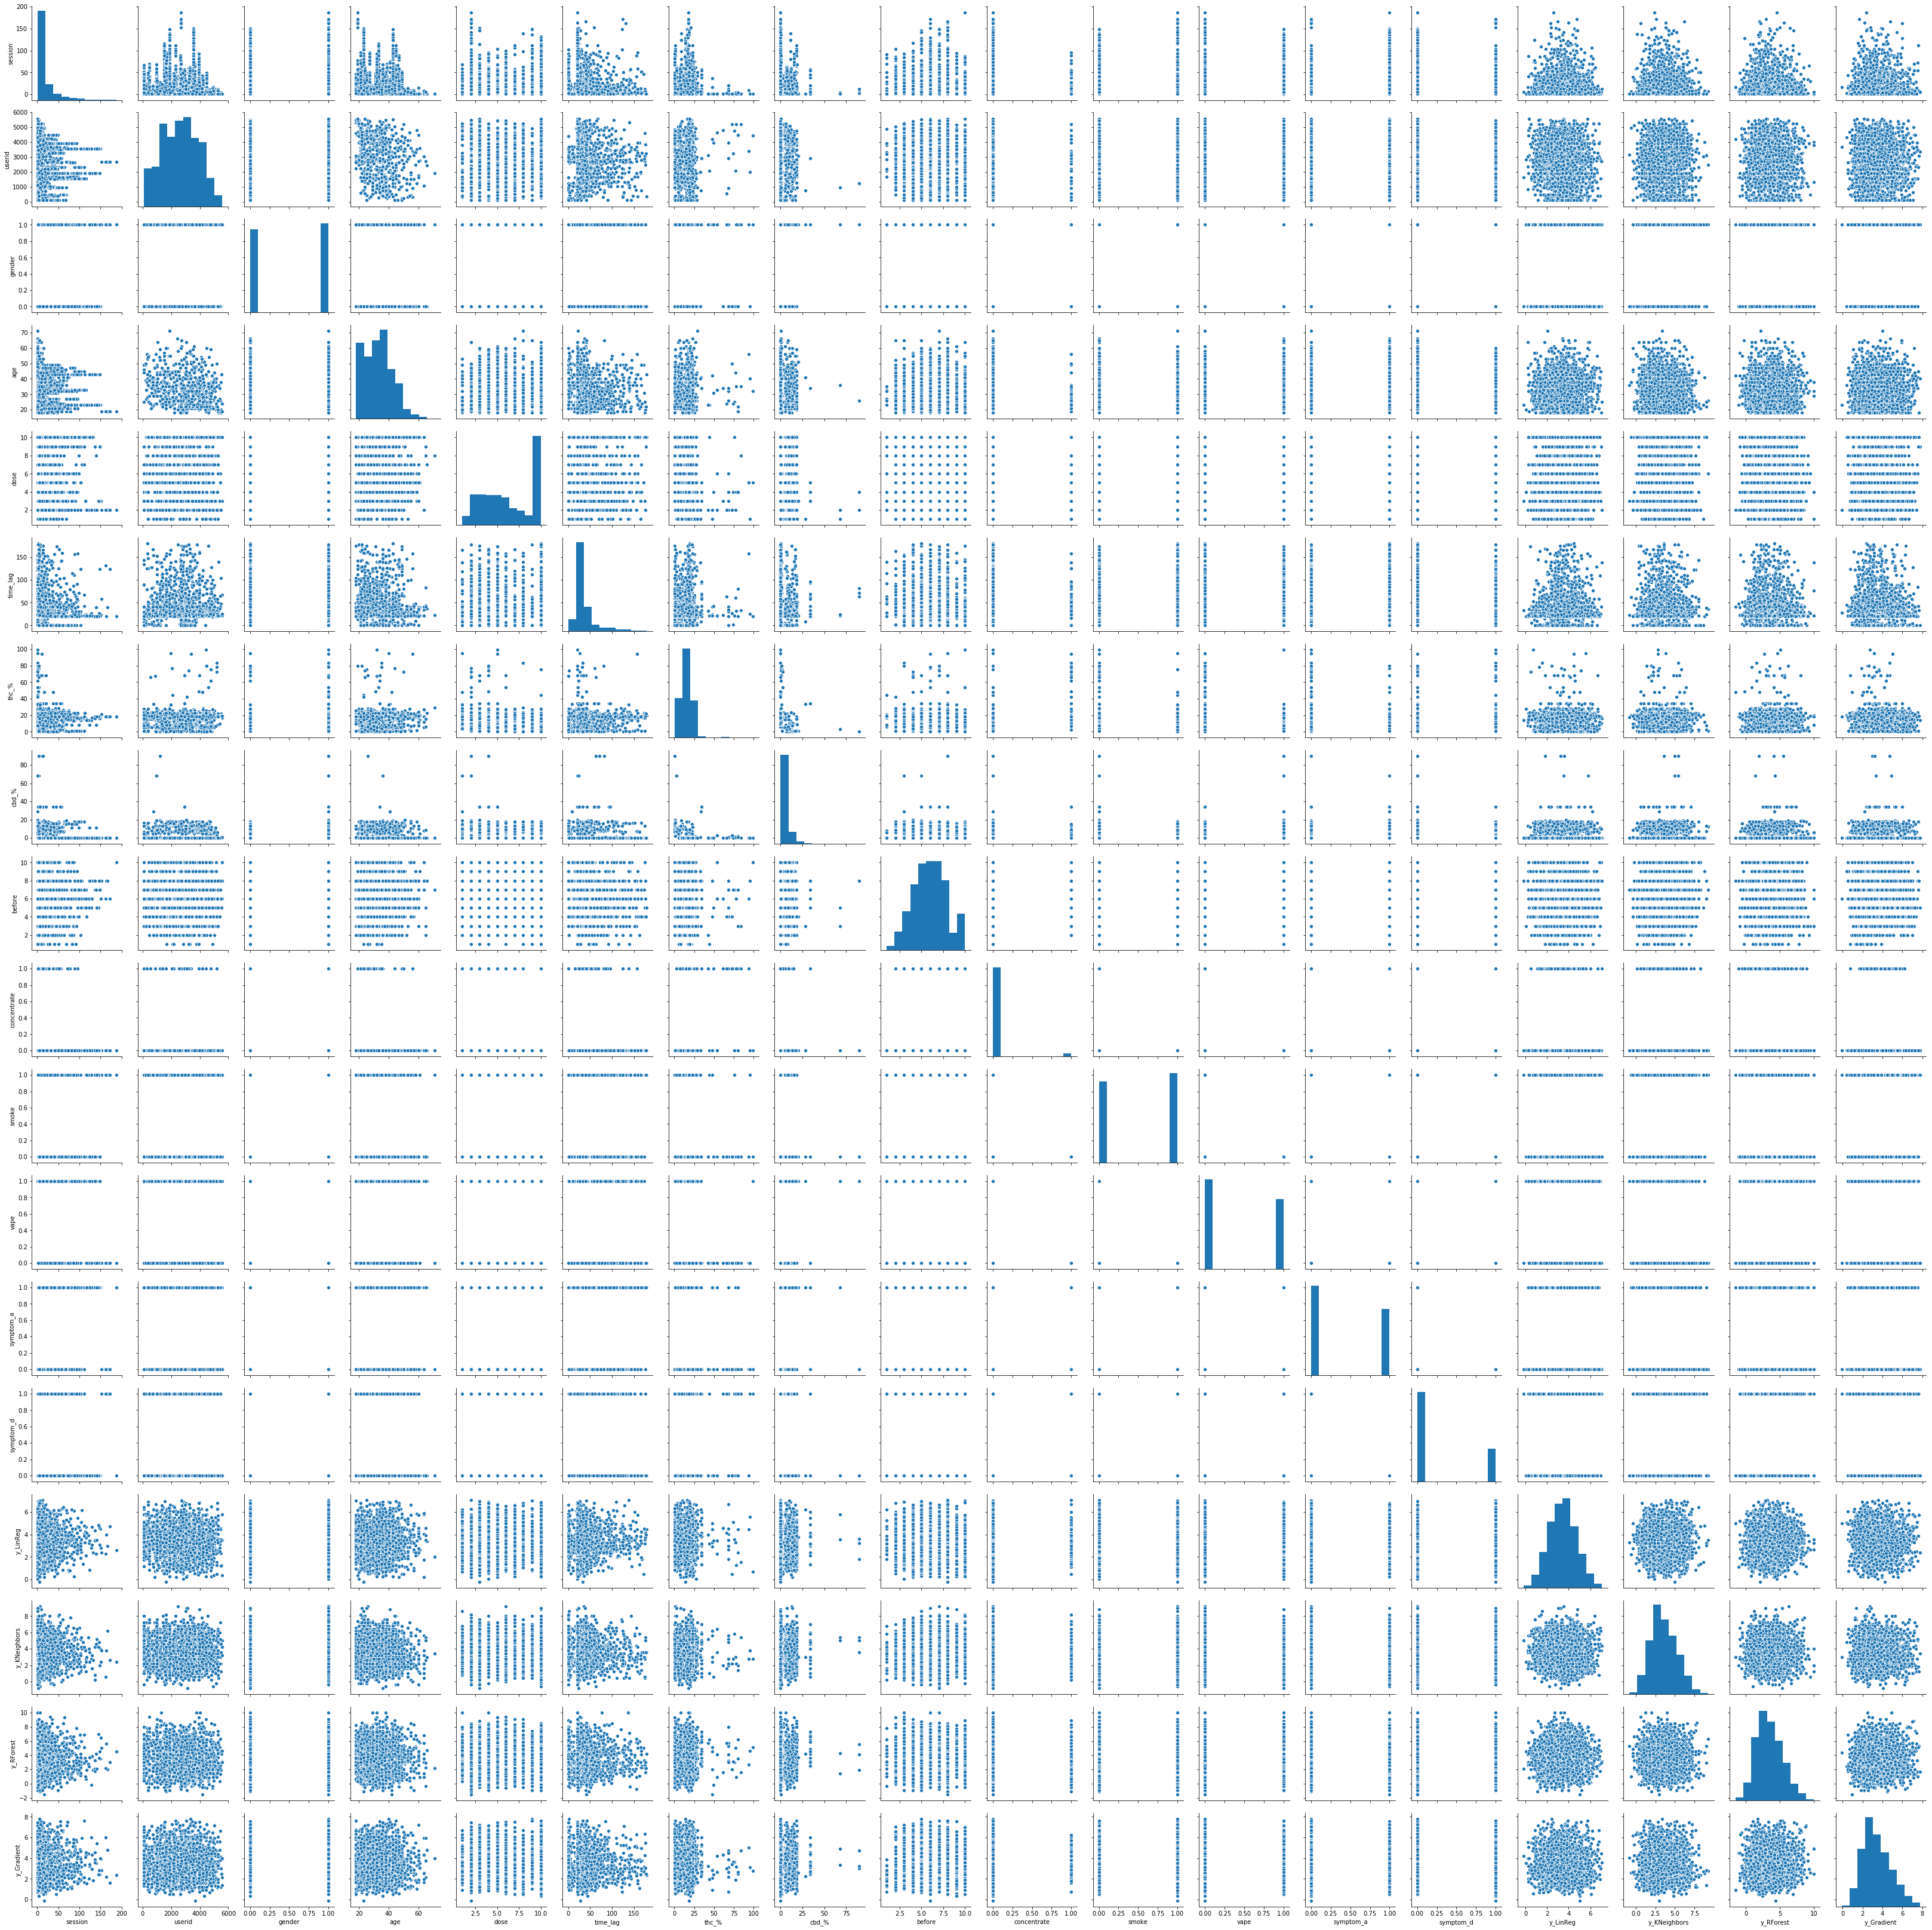

In [134]:
sns.pairplot(X_test_modeled);

## Gaussian Nieve Bayes, Revisited
After seeing that the predictions of all four models fall into a shape resembling a normal distribution, I decided to try Gaussian Nieve Bayes again while including those .

In [144]:
X_g = pd.concat([X_train_modeled, X_test_modeled])[['userid', 'before', 'y_LinReg', 'y_KNeighbors', 'y_RForest', 'y_Gradient']]
y_g = pd.concat([y_train_modeled, y_test_modeled])
X_train, X_test, y_train, y_test = train_test_split(X_g, y_g, random_state=76)

model_gausNB = GaussianNB().fit(X_train, y_train)
Reg_metrics(y_train, model_gausNB.predict(X_train))
Reg_metrics(y_test, model_gausNB.predict(X_test))

RMSE            : 2.326464787449971
Median Abs Error: 1.0
R Squared       : -0.10749132103237025
RMSE            : 2.2708037169175967
Median Abs Error: 1.0
R Squared       : -0.08327784037104724


Welp.
On the otherhand were any of them actually correlated in the more traditional sense?

In [147]:
X_train_modeled.corrwith(y_train_modeled)[-4:]

y_LinReg       -0.019746
y_KNeighbors    0.006603
y_RForest      -0.002470
y_Gradient      0.028454
dtype: float64

This is the first time I've ever tried correlating the predictions to the actual answers and what an odd result I've obtained.

## Code Recycling Bin
- For when I'm not yet ready to delete certain old code.

In [ ]:
# Graph Alterations
# Colors: plt.colors.cnames


# For layering on top:
plt.hist(df['column_1'], color='g')
plt.hist(df['column_2'], color='b')

# For layering next to:
fig, ax = plt.subplots(2, 
                    sharex = True,  # Scale x together
                    sharey = True,    
                   figsize = (1,1)) # Size
ax[0].hist(df['column_1'],          # 
           bins = 10,               # Bins
           color='b',               # Color
           alpha = 0.5,             # Transparancy
           label = 'col_1')         # For .legend()
ax[1].hist(df['column_2'])          # 

# Labels for Words
plt.xlabel("measure",               # Alt: .ylabel
           position = (0,0),        # (x-pos, y-pos)?
           ha = 'left',             # Horizontal
           color = 'grey') # (x,y)

plt.legend()
plt.title()                         # Title ~= Subtitle
plt.suptitle("subtitle\n.",         # Subtitle
             position = (0,1),      # Position
             ha = 'left',           # Horizontal
             fontsize=16,           # Size, Font
             va = 'top');           # Vertical

In [ ]:
# REQUIREMENTS:
# pip install pydot2
# brew install graphviz

# Use graphviz to make a chart of the regression tree decision points:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()  

export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

In [ ]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [86]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
# load dataset
data = load_wine()

# feature matrix
X = data.data

# target vector
y = data.target

# class labels
labels = data.feature_names

# print dataset description
print(data.DESCR)
estimator = DecisionTreeClassifier()
estimator.fit(X, y)

graph = Source(tree.export_graphviz(estimator, out_file=None
   , feature_names=labels, class_names=['0', '1', '2'] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))

Wine Data Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- 1) Alcohol
 		- 2) Malic acid
 		- 3) Ash
		- 4) Alcalinity of ash  
 		- 5) Magnesium
		- 6) Total phenols
 		- 7) Flavanoids
 		- 8) Nonflavanoid phenols
 		- 9) Proanthocyanins
		- 10)Color intensity
 		- 11)Hue
 		- 12)OD280/OD315 of diluted wines
 		- 13)Proline
        	- class:
                - class_0
                - class_1
                - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash: 

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

In [195]:
df.to_csv('./data/Cannibis_6_29.csv', index = False)

list_of_series = []
for num in set(df['age'].unique()):
    mask = df['age'] == num
    list_of_series.append(df[mask]['method'].value_counts(normalize = True))

In [123]:
df_results = X_test
df_results['y_real'] = y_test
df_results['y_hat_forest'] = model.predict(X_test)

In [126]:
df_results['y_real'] = y_test

In [128]:
df_results['Error'] = df_results['y_real'] - df_results['y_hat_forest']

In [132]:
df_results.sort_values('Error')

gender  age  before  concentrate  smoke  vape  y_hat_forest  y_real  \
9837        0   36       8            0      1     0      7.500000       0   
9862        0   34       8            0      1     0      5.285714      -2   
606         1   26      10            0      0     1      7.000000       0   
11080       0   22      10            0      1     0      6.916667       0   
11657       0   24      10            0      0     0      6.500000       0   
2822        0   36       8            0      1     0      7.500000       1   
7302        0   23       9            0      1     0      6.470588       0   
2058        0   38       8            0      1     0      5.236364      -1   
8987        1   30      10            0      1     0      6.125000       0   
5314        1   18      10            0      1     0      7.120000       1   
10460       1   22       5            0      0     0      5.000000      -1   
2943        0   37       7            0      0     1      4.666667      -1   
3025        1   21       7            0      1     0      4.481481      -1   
8259        0   44       8            0      0     1      6.461538       1   
6240        1   21       7            1      0     0      6.363636       1   
4394        1   21       7            1      0     0      6.363636       1   
10683       1   23       8            1      0     0      6.272727       1   
5655        1   25       7            0      1     0      4.166667      -1   
10260       1   18       8            0      0     0      7.090909       2   
5318        1   18       8            0      1     0      7.090909       2   
11834       0   37       9            0      1     0      9.000000       4   
2696        1   29       8            0      1     0      5.000000       0   
1281        1   18       8            0      0     1      8.000000       3   
4843        0   44       9            1      0     0      7.000000       2   
1893        1   18       3            0      1     0      3.000000      -2   
8013        0   31       6            0      1     0      3.928571      -1   
1576        0   22      10            0      1     0      6.916667       2   
7766        1   32       8            0      1     0      4.900000       0   
2876        1   32       8            0      1     0      4.900000       0   
3134        1   21       8            0      1     0      5.892857       1   
...       ...  ...     ...          ...    ...   ...           ...     ...   
3395        0   25       7            0      1     0      2.500000       7   
5233        1   40       7            0      1     0      2.444444       7   
9041        1   38       8            0      1     0      3.428571       8   
6129        0   22       7            0      1     0      1.400000       6   
11662       1   42       7            0      1     0      2.333333       7   
10181       1   25       6            0      1     0      1.230769       6   
4889        1   25       7            0      0     1      2.000000       7   
10027       1   40      10            0      0     1      3.000000       8   
11483       1   24       5            1      0     0     -2.000000       3   
2267        0   28       9            0      1     0      2.000000       7   
1700        1   29       9            0      1     0      3.000000       8   
8483        0   32       8            0      0     1      0.000000       5   
2938        1   42       8            0      1     0      2.789474       8   
3090        1   28      10            1      0     0      3.666667       9   
9825        1   24      10            0      0     1      4.500000      10   
7772        0   22       7            0      1     0      1.400000       7   
6130        0   22       7            0      1     0      1.400000       7   
3562        1   38       7            0      0     1      1.333333       7   
10026       1   40      10            0      1     0      4.333333      10   
11609       1   28       9   

In [212]:
cv = cross_validate(model_lin, X, y, return_train_score=True, scoring='neg_mean_squared_error')#.mean()
cv['test_score']
cv['train_score']

{'fit_time': array([0.01288295, 0.00442696, 0.00669527]),
 'score_time': array([0.00083208, 0.004637  , 0.00084376]),
 'test_score': array([-4.27743923, -3.2569023 , -3.68554284]),
 'train_score': array([-3.2698961 , -3.69505428, -3.5846576 ])}

def Reg_CV_scores(model, X, y):
    cv = cross_validate(model_lin, X, y, return_train_score=True, scoring='neg_mean_squared_error')#.mean()
    print(np.sqrt(cv['test_score'].mean() * -1))
    np.scv['train_score'].mean()

In [97]:
model_NN = Sequential()
model_NN.add(Dense(1,
          activation = 'relu',
          input_dim=X_train.shape[1]))
model_NN.add(Dense(10, activation = 'relu')) # Here, have another layer
model_NN.add(Dense(5, activation = 'relu')) # Here, have another layer
model_NN.add(Dense(1, activation=None))     
model_NN.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse])
results = model_NN.fit(X_train, y_train, 
                    epochs= 50,                               # Default is 1, but start with about 10
                    batch_size = 128,
                    validation_data = (X_test,y_test))

Train on 7509 samples, validate on 2504 samples
Epoch 1/50
7509/7509 [==============================] - 1s 137us/step - loss: 4509.6063 - rmse: 17.6258 - val_loss: 17.8742 - val_rmse: 3.5545
Epoch 2/50
7509/7509 [==============================] - 0s 57us/step - loss: 17.4299 - rmse: 3.5326 - val_loss: 17.3482 - val_rmse: 3.5252
Epoch 3/50
7509/7509 [==============================] - 0s 58us/step - loss: 16.9791 - rmse: 3.5011 - val_loss: 16.9535 - val_rmse: 3.4956
Epoch 4/50
7509/7509 [==============================] - 0s 53us/step - loss: 16.6277 - rmse: 3.4689 - val_loss: 16.5916 - val_rmse: 3.4639
Epoch 5/50
7509/7509 [==============================] - 0s 54us/step - loss: 16.3048 - rmse: 3.4353 - val_loss: 16.2030 - val_rmse: 3.4272
Epoch 6/50
7509/7509 [==============================] - 0s 56us/step - loss: 15.9686 - rmse: 3.3970 - val_loss: 15.8183 - val_rmse: 3.3864
Epoch 7/50
7509/7509 [==============================] - 0s 66us/step - loss: 15.6197 - rmse: 3.3553 - val_loss: 15

Text(0.5,0,'epochs')

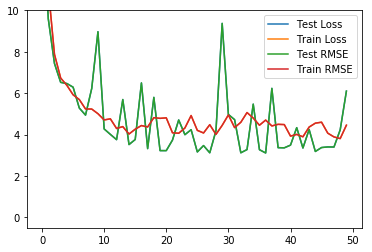

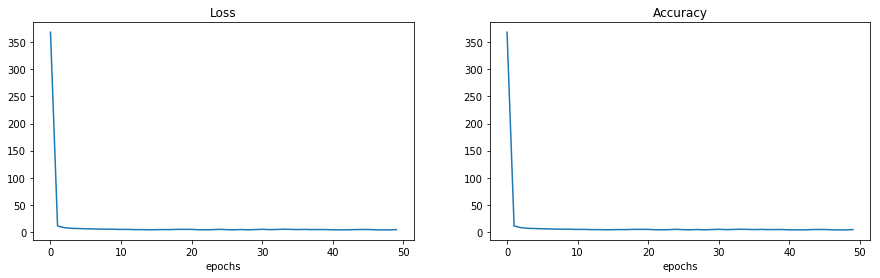

In [140]:
# Visualisations for classification Models
# Plots to view Loss/Accuracy over epoche's
axes = plt.gca()
#axes.set_xlim([-1,35])
axes.set_ylim([-0.5,10])
plt.plot(results.history['val_loss'], label='Test Loss')
plt.plot(results.history['loss'], label='Train Loss')
plt.legend();
plt.plot(results.history['val_mean_squared_error'], label='Test RMSE')
plt.plot(results.history["mean_squared_error"], label='Train RMSE')
plt.legend();

#Alternative
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,4))

ax[0].plot(results.history['loss'])
ax[0].set_title("Loss")
ax[0].set_xlabel("epochs")

ax[1].plot(results.history["mean_squared_error"])
ax[1].set_title("Accuracy")
ax[1].set_xlabel("epochs")